# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
data = pd.read_csv('~/Downloads/ml-intro-2021/5_classification_linear_knn/titanic/train.csv').set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
data.groupby(by=['Sex','Survived'])['Name'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Name, dtype: int64

In [7]:
data.groupby(by=['Sex'])['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Как видим женщины выживали куда чаще. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

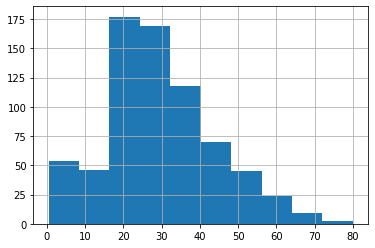

In [8]:
data['Age'].hist()

/Users/daniilkaratsetski/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daniilkaratsetski/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


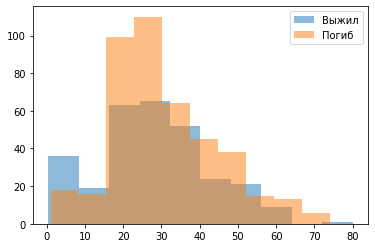

In [9]:
plt.hist(data[data['Survived'] == 1]['Age'], alpha=0.5, label='Выжил')
plt.hist(data[data['Survived'] == 0]['Age'], alpha=0.5, label='Погиб')
plt.legend(loc='upper right')
plt.show()

In [10]:
print(f"Средний возраст выживших: {data[data['Survived'] == 1]['Age'].mean()} \nМедианный возраст выживших: {data[data['Survived'] == 1]['Age'].median()}")

Средний возраст выживших: 28.343689655172415 
Медианный возраст выживших: 28.0


In [11]:
print(f"Средний возраст погибших: {data[data['Survived'] == 0]['Age'].mean()} \nМедианный возраст погибших: {data[data['Survived'] == 0]['Age'].median()}")

Средний возраст погибших: 30.62617924528302 
Медианный возраст погибших: 28.0


Медианы одинаковы, а средний возраст близок. Однако при просмотре гистограммы видно, что молодые погибали чаще. Думаю это может служить хорошим примером тогом, что не смотря на примерно одинаковые статистики, распределения могут значительно отличаться

Можно сделать вывод что старались спасти стариков и детей. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [12]:
data.groupby(by=['Pclass','Embarked'])['Survived'].mean()

Pclass  Embarked
1       C           0.694118
        Q           0.500000
        S           0.582677
2       C           0.529412
        Q           0.666667
        S           0.463415
3       C           0.378788
        Q           0.375000
        S           0.189802
Name: Survived, dtype: float64

Как видно 1 и 2 классы были относительно безопасными. В то же время, третий класс достаточно опасен. 
При этом пока не видно зависимости между портом и выживаемостью.

In [13]:
data.groupby(by=['Embarked'])['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Тут видно что порт C более безопасен, однако с чем это связано хороший вопрос

In [14]:
data[data['Embarked'] == 'C'].groupby(by='Pclass')['Name'].count()

Pclass
1    85
2    17
3    66
Name: Name, dtype: int64

In [15]:
data[data['Embarked'] == 'C'].groupby(by='Sex')['Name'].count()

Sex
female    73
male      95
Name: Name, dtype: int64

Более высокую выживаемость можно объяснить большим кол-вом пассажиров 1 и 2 класса. 

In [16]:
data.groupby(by=['Embarked','Pclass'])['Name'].count()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Name, dtype: int64

Действительно, С единственный порт, где большая часть пассажиров первого или второго класса. Однако тогда странно,что выживаемость Q больше чем S. Тк в Q практически все пассажиры 3 класса

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [17]:
pd.isnull(data).sum() > 0

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Из EDA видно что выживаемость для разных классов и полов сильно отличается, лучшим способом будет заполнение пропусков медианным значением части датасета с определенным полом и классом. 

В следующем задании попробую это реализовать. 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [18]:
y = data['Survived']

В первую очередь давайте заполним пропуски. Я хочу проверить, является ли пропуск в графе возраст чертой, какого-то класса или порта. Например, работники какого-то из портов былии более халатными или пассажиры определенного класса скрывали свой возраст.  

In [19]:
data[data['Age'].isna()].groupby(by=['Embarked'])['Name'].count()

Embarked
C    38
Q    49
S    90
Name: Name, dtype: int64

In [20]:
data.groupby(by=['Embarked'])['Name'].count()

Embarked
C    168
Q     77
S    644
Name: Name, dtype: int64

In [21]:
data[data['Age'].isna()].groupby(by=['Pclass'])['Name'].count()

Pclass
1     30
2     11
3    136
Name: Name, dtype: int64

In [22]:
data.groupby(by=['Pclass'])['Name'].count()

Pclass
1    216
2    184
3    491
Name: Name, dtype: int64

Вроде каких то явных отличий нет.
Давайте рассмотрим распделение возраста по для каждого класса и пола 

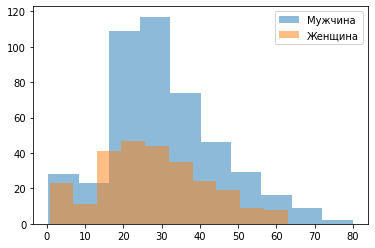

In [23]:
plt.hist(data[data['Sex'] == 'male']['Age'], alpha=0.5, label='Мужчина')
plt.hist(data[data['Sex'] == 'female']['Age'], alpha=0.5, label='Женщина')
plt.legend(loc='upper right')
plt.show()

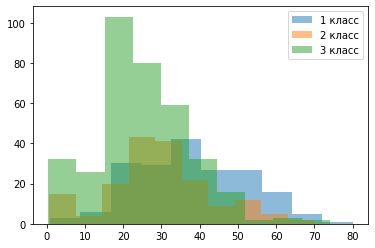

In [24]:
plt.hist(data[data['Pclass'] == 1]['Age'], alpha=0.5, label='1 класс')
plt.hist(data[data['Pclass'] == 2]['Age'], alpha=0.5, label='2 класс')
plt.hist(data[data['Pclass'] == 3]['Age'], alpha=0.5, label='3 класс')
plt.legend(loc='upper right')
plt.show()

Судя по гистограммам стоит использовать медиану, а не среднее

In [25]:
median_female1 = data[(data['Sex'] == 'female') & (data['Pclass'] == 1)]['Age'].median()
median_female2 = data[(data['Sex'] == 'female') & (data['Pclass'] == 2)]['Age'].median()
median_female3 = data[(data['Sex'] == 'female') & (data['Pclass'] == 3)]['Age'].median()
median_male1 = data[(data['Sex'] == 'male') & (data['Pclass'] == 1)]['Age'].median()
median_male2 = data[(data['Sex'] == 'male') & (data['Pclass'] == 2)]['Age'].median()
median_male3 = data[(data['Sex'] == 'male') & (data['Pclass'] == 3)]['Age'].median()

In [26]:
data.sort_values(by='Age')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [27]:
cols = ['Pclass', 'Sex']
age_class_sex = data.groupby(cols)['Age'].median().reset_index()

In [28]:
age_class_sex

,Pclass,Sex,Age
0,1,female,35.0
1,1,male,40.0
2,2,female,28.0
3,2,male,30.0
4,3,female,21.5
5,3,male,25.0


In [29]:
data['Age'] = data['Age'].fillna(data[cols].reset_index().merge(age_class_sex, how='left', on=cols).set_index('PassengerId')['Age'])

In [30]:
data.fillna({'Embarked':data['Embarked'].mode().iloc[0]},inplace=True)

In [31]:
pd.isnull(data).sum() > 0

Survived    False
Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked    False
dtype: bool

Вроде как своего мы добились, пропусков в возрасте и порту нет. 

In [32]:
y = data['Survived']
X = data.drop(columns=['Name',"Cabin",'Ticket','Survived'])

In [33]:
X = pd.get_dummies(X)

In [34]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [36]:
clf_reg = LogisticRegression()

In [37]:
cross_val_score(clf_reg, X, y, scoring='accuracy', cv=5).mean()

0.7991212102190698

In [38]:
knn = KNeighborsClassifier(2)
cross_val_score(knn, X, y, scoring='accuracy', cv=5).mean()

0.7766932395957566

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Некоторые идеи и методы были взяты из ноутбуков на kaggle

In [39]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['Name_length'] = data['Name'].apply(len)
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

In [40]:
data['Title']=0
data['Title']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
data['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [41]:
y = data['Survived']
X = data.drop(columns=['Name',"Cabin",'Ticket','Survived'])

In [42]:
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize','Name_length']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Pclass','Sex','Embarked','IsAlone','Title']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(2))])

In [43]:
cross_val_score(pipe_knn, X, y, scoring='accuracy', cv=5).mean()

0.7901387232439897

In [44]:
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize','Name_length']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Pclass','Sex','Embarked','IsAlone','Title']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_log_l1 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear',penalty='l1', C=0.5, class_weight='balanced'))])

In [45]:
cross_val_score(pipe_log_l1, X, y, scoring='accuracy', cv=5).mean()

0.8159500345238844

In [46]:
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize','Name_length']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['Pclass','Sex','Embarked','IsAlone','Title']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_log_l2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(penalty='l2', C=0.5, class_weight='balanced'))])

In [47]:
cross_val_score(pipe_log_l2, X, y, scoring='accuracy', cv=5).mean()

0.8215617349821104

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [48]:
titanic_test = pd.read_csv('~/Downloads/ml-intro-2021/5_classification_linear_knn/titanic/test.csv').set_index('PassengerId')

In [49]:
age_class_sex = titanic_test.groupby(cols)['Age'].median().reset_index()
titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test[cols].reset_index().merge(age_class_sex, how='left', on=cols).set_index('PassengerId')['Age'])
titanic_test.fillna({'Embarked':titanic_test['Embarked'].mode().iloc[0]},inplace=True)

In [50]:
pd.isnull(titanic_test).sum() > 0

Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare         True
Cabin        True
Embarked    False
dtype: bool

In [51]:
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].median())

In [52]:
titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch'] + 1
titanic_test['Name_length'] = titanic_test['Name'].apply(len)
titanic_test['IsAlone'] = 0
titanic_test.loc[titanic_test['FamilySize'] == 1, 'IsAlone'] = 1

In [53]:
titanic_test['Title']=0
titanic_test['Title']=titanic_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
titanic_test['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [54]:
titanic_test.drop(columns=['Name',"Cabin",'Ticket'],inplace=True)

In [55]:
pd.isnull(titanic_test).sum() > 0

Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Embarked       False
FamilySize     False
Name_length    False
IsAlone        False
Title          False
dtype: bool

In [56]:
pipe_knn.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                        

In [57]:
pred_knn = pipe_knn.predict(titanic_test)

In [58]:
base_submission = pd.read_csv('~/Downloads/ml-intro-2021/5_classification_linear_knn/titanic/gender_submission.csv')

In [59]:
titanic_submission = pd.DataFrame({"PassengerId": base_submission["PassengerId"], "Survived": pred_knn})
titanic_submission.to_csv('knn.csv', index=False)

In [60]:
pipe_log_l1.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                        

In [61]:
pred_l1 = pipe_log_l1.predict(titanic_test)

In [62]:
titanic_submission = pd.DataFrame({"PassengerId": base_submission["PassengerId"], "Survived": pred_l1})
titanic_submission.to_csv('l1.csv', index=False)

Результат 0.76315.

In [63]:
pipe_log_l2.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'FamilySize',
                                        

In [64]:
pred_l2 = pipe_log_l2.predict(titanic_test)

In [65]:
titanic_submission = pd.DataFrame({"PassengerId": base_submission["PassengerId"], "Survived": pred_l2})
titanic_submission.to_csv('l2.csv', index=False)

Результат 0.75358.

В итоге оказалось что лучший результат продемонстрировала модель логистической регрессии с регуляризации l1. Возможно причина кроется в том, что было сгенерировано достаточно много признаков, и при помощи l1 были отобраны лучшие. 

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [112]:
insurance_data = pd.read_csv('~/Downloads/ml-intro-2021/5_classification_linear_knn/porto-seguro-safe-driver-prediction/train.csv').set_index('id')
base_insurance_submission = pd.read_csv('~/Downloads/ml-intro-2021/5_classification_linear_knn/porto-seguro-safe-driver-prediction/sample_submission.csv')
test_insurance = pd.read_csv('~/Downloads/ml-intro-2021/5_classification_linear_knn/porto-seguro-safe-driver-prediction/test.csv')

In [67]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [114]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [117]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [72]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

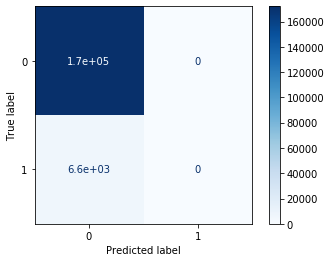

In [73]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [74]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

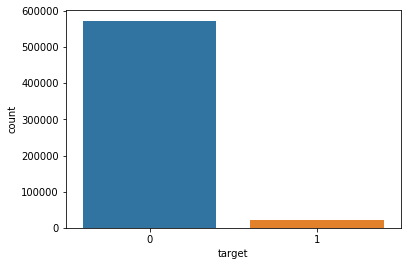

In [75]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [76]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

In [77]:
from sklearn.metrics import roc_auc_score

In [78]:
2 * roc_auc_score(y_valid,clf.predict_proba(X_valid)[:,1]) - 1 - gini_normalized(y_valid, clf.predict_proba(X_valid)[:, 1]) 

1.173261487963373e-11

Оказывается необходимо строгое доказательство, поэтому этот ответ на засчитывай.
Вот тут есть достаточно интересная статья про него https://m.habr.com/ru/company/ods/blog/350440/

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

ROC-AUC, F-score

Let's calculate the Normalized Gini Coefficient:

In [79]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [80]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

Я не понял как использовать gini в кросс валидации, поэтому буду использовать ROC-AUC. Тк судя по формуле они связаны, и рост ROC-AUC будет означать рост коэффициента джини. Если ты знаешь как использовать в кросс валидации gini, пожалуйста напиши об этом в отзыве 

In [104]:
cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5).mean()

0.6293455850743019

In [118]:
pipeline.fit(X,y)
pipeline_submission = pipeline.predict_proba(test_insurance)[:, 1]
insurance_submission = pd.DataFrame({"id": base_insurance_submission["id"], "target": pipeline_submission})
insurance_submission.to_csv('pipeline_submission.csv', index=False)

/Users/daniilkaratsetski/opt/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Тк можно использовать леса и подбор гиперпараметров,давайте попробуем ими повысить скор

In [156]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [128]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [136]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_logistic = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logistic', LogisticRegression(solver='saga', penalty='elasticnet', random_state=14,max_iter=10000))])

parameters = {'logistic__C': np.logspace(-4, 4, 4),
             'logistic__l1_ratio':np.arange(0,1,0.1)}

In [144]:
rand = GridSearchCV(estimator=pipe_logistic, param_grid=parameters, cv=3, verbose=5, n_jobs=6,scoring='roc_auc')

In [145]:
rand.fit(X_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 159.1min
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed: 452.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                        

In [146]:
rand.best_score_

0.6287800598709753

In [147]:
rand.best_params_

{'logistic__C': 0.046415888336127774, 'logistic__l1_ratio': 0.7000000000000001}

In [153]:
logistic = rand.best_estimator_

In [ ]:
logistic.fit(X,y)

In [ ]:
gini_normalized(y_valid, logistic.predict_proba(X_valid)[:, 1])

In [ ]:
logistic_submission = pipeline.predict_proba(test_insurance)[:, 1]
insurance_submission = pd.DataFrame({"id": base_insurance_submission["id"], "target": logistic_submission})
insurance_submission.to_csv('pipeline_submission.csv', index=False)

In [148]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_tree = Pipeline(steps=[('preprocessor', preprocessor),
                           ('tree', DecisionTreeClassifier(random_state=14))])

parameters = {'tree__criterion': ['gini','entropy'],
             'tree__max_depth':np.arange(2,15,2),
             'tree__min_samples_split':np.arange(2,150,5),
             'tree__min_samples_leaf':np.arange(2,150,5)}

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
rand = RandomizedSearchCV(estimator=pipe_tree, param_distributions=parameters, cv=3, verbose=5, n_jobs=6,scoring='roc_auc',n_iter = 200)

In [ ]:
rand.fit(X_train,y_train)

In [ ]:
rand.best_score_

In [ ]:
rand.best_params_

In [107]:
selection_model = RandomForestClassifier(random_state=42)
selector = SelectFromModel(selection_model).fit(X, y)

In [108]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

#selection_model = RandomForestClassifier(random_state=42)
#selector = SelectFromModel(selection_model).fit(X, y)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_feature_selection = Pipeline(steps=[('preprocessor', preprocessor),('selector',SelectFromModel(selection_model)),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [109]:
cross_val_score(pipe_feature_selection, X, y, scoring='roc_auc', cv=3,verbose=5,n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 55.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 55.6min finished


0.6043678004387335

In [110]:
pipe_feature_selection.fit(X,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['ps_ind_01', 'ps_ind_03',
                                                   'ps_ind_14', 'ps_ind_15',
                                   

In [111]:
pipe_feature_selection_submission = pipe_feature_selection.predict_proba(test_insurance)[:, 1]

/Users/daniilkaratsetski/opt/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [112]:
insurance_submission = pd.DataFrame({"id": base_insurance_submission["id"], "target": pipe_feature_selection_submission})
insurance_submission.to_csv('pipe_feature_selection_submission.csv', index=False)

In [113]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline_l1 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', penalty='l1', alpha=0.001, n_jobs=-1, random_state=14))])

In [114]:
cross_val_score(pipeline_l1, X, y, scoring='roc_auc', cv=3,verbose=5,n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished


0.6217014013580765

In [115]:
pipeline_l1.fit(X,y)
pipeline_l1_submission = pipeline_l1.predict_proba(test_insurance)[:, 1]
insurance_submission = pd.DataFrame({"id": base_insurance_submission["id"], "target": pipeline_l1_submission})
insurance_submission.to_csv('pipeline_l1_submission.csv', index=False)

/Users/daniilkaratsetski/opt/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [116]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

#selection_model = RandomForestClassifier(random_state=42)
#selector = SelectFromModel(selection_model).fit(X, y)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_feature_selection_l2 = Pipeline(steps=[('preprocessor', preprocessor),('selector',SelectFromModel(selection_model)),
                           ('classifier', SGDClassifier(loss='log', penalty='l2', alpha=0.001, n_jobs=-1, random_state=14))])

In [117]:
cross_val_score(pipe_feature_selection_l2, X, y, scoring='roc_auc', cv=3,verbose=1,n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 48.0min finished


0.6043678004387335

In [118]:
pipe_feature_selection_l2.fit(X,y)
pipe_feature_selection_l2_submission = pipe_feature_selection_l2.predict_proba(test_insurance)[:, 1]
insurance_submission = pd.DataFrame({"id": base_insurance_submission["id"], "target": pipe_feature_selection_l2_submission})
insurance_submission.to_csv('pipe_feature_selection_l2_submission.csv', index=False)

/Users/daniilkaratsetski/opt/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Самым эффективным к удивлению оказался базовая модель. 
Получила 0.26162 на private и 0.25518 на public. 

$\frac{round(200 * \max(score - 0.253, 0))}{2}$

In [122]:
print(np.round(200*(0.26162-0.253))/2,' private')

1.0  private


In [123]:
print(np.round(200*(0.25518-0.253))/2,' public')

0.0  public
